<a href="https://colab.research.google.com/github/JonysArcanjo/Landmark_Detection_with_MediaPipe/blob/main/Deteccao_facial_e_landmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 37.1 MB/s eta 0:00:00


# Módulo 04 - Detecção e Reconhecimento Facial

A face é crucial na interação visual, sendo capaz de revelar informações não-verbais valiosas, como identificação, intenções e sentimentos, presentes em expressões faciais humanas. A análise de expressões faciais se torna uma área fascinante para quem estuda visão computacional, pois intersecta campos como reconhecimento de objetos, tratamento de imagens e identificação ou rastreio de pontos característicos (*landmarks*).

**Este notebook tem como foco a análise, detecção e reconhecimento facial**, um campo que tem ganhado destaque na área de inteligência artificial, uma vez que é possível obter uma riqueza de dados a partir de rostos por meio de algoritmos de visão computacional.




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 4.1 - Evolução dos Algoritmos de Detecção de Rosto

Ao longo do tempo, diversos algoritmos de detecção de rosto têm sido desenvolvidos, cada um com seus méritos e aplicações específicas. Iniciantes na área podem se sentir sobrecarregados pela diversidade de tutoriais disponíveis - uns focando em Haar Cascades, outros na biblioteca dlib e, mais recentemente, a ascensão do MediaPipe, que tem ganhado destaque a ponto de ofuscar alternativas tradicionais como o SSD (*Single Shot Multibox Detector*).

Para ilustrar essa evolução e ajudar na compreensão desse campo, a figura abaixo (retirada do artigo [What is Face Detection](https://learnopencv.com/what-is-face-detection-the-ultimate-guide/)) oferece um panorama dos algoritmos ao longo do tempo. **Mas como navegar por essa variedade sem se perder? Como tomar a melhor decisão para sua aplicação?**

![Imagens](img/timeline-of-face-detection-methods.png)


### Escolhendo o modelo ideal

O modelo perfeito para detecção facial deve alinhar-se com os requisitos únicos do seu projeto. O autor do artigo mencionado sugere que a decisão deve ser pautada por três critérios fundamentais:

**Precisão de Detecção Superior:** Caso a prioridade seja capturar cada rosto com a maior precisão possível, os algoritmos DSFD ou RetinaFace-resnet50 emergem como as melhores escolhas. No entanto, é preciso estar ciente de que a alta complexidade de tais modelos resulta em uma velocidade de inferência reduzida, o que pode ser um empecilho para aplicações que exigem resposta em tempo real.

**Velocidade de Detecção Máxima:** Se o que importa é a rapidez da inferência, mesmo que isso signifique perder algumas detecções em cenários complexos, a solução de detecção facial do MediaPipe é a alternativa ideal.

**Melhor custo beneficio  entre velocidade e precisão:** Para aqueles que procuram um meio-termo, os modelos YuNet e RetinaFace-Mobilenetv1 apresentam-se como candidatos equilibrados. Eles oferecem uma velocidade de inferência rápida, adequada para aplicações em tempo real, sem sacrificar demasiadamente a precisão.

Selecionar o algoritmo correto é um passo decisivo que pode determinar o sucesso da sua aplicação. Neste módulo, nós trabalharemos especificamente com:

* Módulo DNN do OpenCV
* MediaPipe Solutions

## 4.2 - Utilizando o Módulo DNN do OpenCV para Detecção de Rosto

O OpenCV oferece ferramentas robustas para a detecção de rostos através do seu módulo de Redes Neurais Profundas (DNN - *Deep Neural Network*). Este módulo incorpora a capacidade de execução de passagens diretas (inferência) utilizando redes neurais pré-treinadas provenientes de diversos frameworks, tais como Caffe, TensorFlow, Torch e Darknet.

Desde a versão 3.1 do OpenCV, o módulo DNN tem se tornado um componente valioso, uma vez que permite a realização de inferências sem a necessidade de treinamento da rede. A partir da versão 3.3, o módulo foi incorporado ao repositório principal do OpenCV, passando por otimizações e acelerações significativas.

### 4.2.1 - *Single Shot Multibox Detector* - SSD

O detector de rosto disponibilizado pelo OpenCV é construído sobre o framework SSD (*Single Shot MultiBox Detector*) utilizando uma arquitetura de rede ResNet-10. A capacidade deste detector reside na sua habilidade de identificar e localizar rostos em imagens, fazendo uso de modelos pré-treinados que simplificam a implementação e integração em diversas aplicações.

O OpenCV disponibiliza dois modelos específicos para a detecção de rosto:

1. **Detector de Rosto (FP16)**: Esta versão utiliza uma representação *float-point** de 16 bits da implementação original em Caffe.
2. **Detector de Rosto (UINT8)**: Trata-se de uma versão quantizada de 8 bits utilizando TensorFlow.

Para a utilização de ambos os modelos, são necessários dois conjuntos de arquivos: **o arquivo de modelo, contendo os pesos das camadas da rede, e o arquivo de configuração, que define a arquitetura da rede neural.**

#### Modelo Caffe
- **res10_300x300_ssd_iter_140000_fp16.caffemodel**: Contém os pesos das camadas da rede.
- **deploy.prototxt**: Define a arquitetura da rede neural.

#### Modelo TensorFlow
- **opencv_face_detector_uint8.pb**: Contém os pesos das camadas da rede.
- **opencv_face_detector.pbtxt**: Define a arquitetura do modelo.

### 4.2.2 - Aplicação Prática do Módulo DNN


In [4]:
# Importando as bibliotecas necessárias
import cv2
import numpy as np
#import sigmoidal as sig

%matplotlib inline

## support

In [5]:
from typing import List, Optional, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np


def plot_images_grid(
    images: List[np.ndarray],
    grid_size: Tuple[int, int],
    titles: Optional[List[str]] = None,
    size: Tuple[int, int] = (10, 10),
    cmap: str = 'gray',
) -> None:
    """
    Display a grid of images with optional titles.

    Parameters
    ----------
    images : List[np.ndarray]
        A list of images to be displayed. Each image should be a NumPy array.

    grid_size : Tuple[int, int]
        A tuple specifying the number of rows and columns in the grid layout.

    titles : Optional[List[str]], default=None
        An optional list of titles for each subplot. The list should have the same length as `images`.

    size : Tuple[int, int], default=(10, 10)
        A tuple specifying the width and height of the entire plot figure.

    cmap : str, default='gray'
        The colormap used for displaying single-channel images.

    Raises
    ------
    ValueError
        If the number of images exceeds the total spots in the grid.

    Example
    -------
    >>> images = [np.random.rand(10, 10) for _ in range(4)]
    >>> plot_images_grid(images, grid_size=(2, 2), titles=['Img1', 'Img2', 'Img3', 'Img4'])

    Returns
    -------
    None
    """
    rows, cols = grid_size

    if len(images) > rows * cols:
        raise ValueError('Number of images exceeds grid size.')

    # Creating a figure with a specified size
    plt.figure(figsize=size)

    for i, img in enumerate(images):
        # Creating subplots
        plt.subplot(rows, cols, i + 1)

        # If the image is single channel (like grayscale), use the specified colormap
        if len(img.shape) == 2:
            plt.imshow(img, cmap=cmap)
        else:
            # Convert from BGR to RGB since OpenCV loads in BGR format
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

        # Optional titles
        if titles is not None:
            plt.title(titles[i])

        # Removing x and y ticks
        plt.xticks([])
        plt.yticks([])

    plt.show()


def plot_image(
    image: np.ndarray,
    size: Tuple[int, int] = (5, 5),
    cmap: Optional[str] = 'gray',
) -> None:
    """
    Display an image loaded with OpenCV in a Jupyter notebook.

    Parameters
    ----------
    image : np.ndarray
        The image to be displayed.

    size : Tuple[int, int], default=(10, 10)
        The size of the figure in which the image will be displayed (width, height).

    cmap : Optional[str], default='gray'
        The colormap to be used if the image is grayscale.

    Returns
    -------
    None
    """
    plt.figure(figsize=size)

    if image.ndim == 2:
        plt.imshow(image, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    plt.axis('off')
    plt.show()


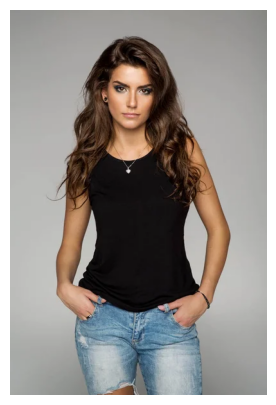

In [6]:
# Carregando a imagem
img = cv2.imread('/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/modelo.jpg')

# Exibindo a imagem usando a função plot_image da biblioteca sigmoidal
plot_image(img)

### 4.3.1 - Leitura do Modelo DNN

A função readNetFromCaffe é utilizada para carregar um modelo de rede neural pré-treinado armazenado no formato do framework Caffe. Esta função é frequentemente utilizada na preparação de modelos para detecção e classificação em tarefas de visão computacional. Ela lê os arquivos de descrição da arquitetura da rede e os pesos aprendidos durante o treinamento e cria uma instância da rede neural para inferência.

#### <font style="color:rgb(0, 0, 128)">Sintaxe da Função</font>

```python
cv2.dnn.readNetFromCaffe(
    prototxt: str,
    caffeModel: str
) -> cv2.dnn_Net
```

**Parâmetros**<br>

- **prototxt** (*str*): Caminho para o arquivo .prototxt que contém a descrição textual da arquitetura da rede neural.
- **caffeModel** (*str*): Caminho para o arquivo .caffemodel que contém os pesos da rede neural treinada.

**Retorno**<br>

- **cv2.dnn_Net**: Retorna uma instância da rede neural para inferência.


In [7]:
# Carrega o modelo
model = cv2.dnn.readNetFromCaffe('/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/models/deploy.prototxt', '/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/models/res10_300x300_ssd_iter_140000.caffemodel')

### 4.3.2 - Conversão de Imagem para Blob

A função blobFromImage é usada para criar um blob 4-dimensional a partir de uma imagem. Opcionalmente, redimensiona e corta a imagem a partir do centro, subtrai valores médios, escala valores pelo fator de escala e troca os canais Azul e Vermelho.

#### <font style="color:rgb(0, 0, 128)">Sintaxe da Função</font>

```python
cv2.dnn.blobFromImage(
    image: np.ndarray,
    scalefactor: Optional[float] = 1.0,
    size: Optional[Tuple[int, int]] = (0, 0),
    mean: Optional[Tuple[float, float, float]] = (0.0, 0.0, 0.0),
    swapRB: Optional[bool] = True,
    crop: Optional[bool] = False,
    ddepth: Optional[int] = cv2.CV_32F
) -> np.ndarray
```

**Parâmetros**<br>

- **image** (*np.ndarray*): Imagem de entrada (com 1, 3 ou 4 canais).
- **scalefactor** (*float, opcional*): Multiplicador para os valores da imagem.
- **size** (*Tuple[int, int], opcional*): Tamanho espacial para a imagem de saída.
- **mean** (*Tuple[float, float, float], opcional*): Escalar com valores médios que são subtraídos dos canais.
- **swapRB** (*bool, opcional*): Indica se a troca dos canais primeiro e último em uma imagem de 3 canais é necessária.
- **crop** (*bool, opcional*): Indica se a imagem será cortada após o redimensionamento.
- **ddepth** (*int, opcional*): Profundidade do blob de saída. Escolha entre CV_32F ou CV_8U.

**Retorno**<br>

- **np.ndarray**: Retorna a imagem de saída do mesmo tamanho e profundidade que a imagem de entrada.

In [8]:
# Cria um blob a partir da imagem
img_copy = img.copy()

blob = cv2.dnn.blobFromImage(cv2.resize(
    img_copy, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))

### 4.3.3 - Configurando o Valor de Entrada

A função setInput define um novo valor de entrada para a rede neural.

#### <font style="color:rgb(0, 0, 128)">Sintaxe da Função</font>

```python
cv2.dnn_Net.setInput(
    blob: np.ndarray,
    name: Optional[str] = None,
    scalefactor: Optional[float] = None,
    mean: Optional[Tuple[float, float, float]] = None
) -> None
```

**Parâmetros**<br>

- **blob** (*np.ndarray*): Novo blob.
- **name** (*str, opcional*): Nome da camada de entrada.
- **scalefactor** (*float, opcional*): Fator de normalização opcional.
- **mean** (*Tuple[float, float, float], opcional*): Valores de subtração de média opcionais.

**Retorno**<br>

- **None**

In [9]:
# Define o blob como entrada para o modelo
model.setInput(blob)

### 4.3.4 - Detecções Usando o Modelo DNN

A função forward executa uma passagem para frente para calcular a saída de uma camada com o nome outputName. Retorna o blob para a primeira saída da camada especificada.

#### <font style="color:rgb(0, 0, 128)">Sintaxe da Função</font>

```python
cv2.dnn_Net.forward(
    outputName: Optional[str] = None
) -> np.ndarray
```

**Parâmetros**<br>

- **outputName** (*str, opcional*): Nome da camada para a qual a saída é necessária.

**Retorno**<br>

- **np.ndarray**: Retorna o blob para a primeira saída da camada especificada.

In [10]:
# Executa uma passagem para frente (forward pass) através do modelo
detections = model.forward()

Agora, já com as detecções, primeiramente são extraídas as dimensões da imagem de entrada `img_copy`, especificamente a altura (`h`) e a largura (`w`). Isso é feito para posteriormente ajustar as coordenadas dos retângulos delimitadores das detecções em relação ao tamanho real da imagem. Em seguida, o código entra em um laço para iterar sobre todas as detecções disponíveis, que estão armazenadas na matriz `detections`.

Dentro *loop*, para cada detecção, se obtém o valor de confiança associado, que indica quão confiante o modelo está de que a região detectada contém um rosto. Um *threshold* é definido, e somente as detecções que superam esse limiar são consideradas. Para essas detecções, o código calcula as coordenadas do retângulo delimitador ajustadas ao tamanho da imagem, converte essas coordenadas para inteiros e, em seguida, desenha o retângulo e exibe o valor de confiança na imagem `img_copy`.


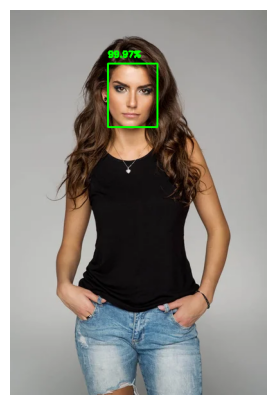

In [11]:
# Obtém as dimensões da imagem
(h, w) = img_copy.shape[:2]

# Itera sobre as detecções
for i in range(detections.shape[2]):
    # Obtém a confiança da detecção
    confidence = detections[0, 0, i, 2]

    # Define um limiar de confiança para considerar uma detecção válida
    confidence_threshold = 0.5

    # Verifica se a confiança é maior que o limiar
    if confidence > confidence_threshold:
        # Obtém as coordenadas do retângulo delimitador
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])

        # Converte as coordenadas para inteiros
        (startX, startY, endX, endY) = box.astype("int")

        # Desenha o retângulo delimitador na imagem
        cv2.rectangle(img_copy, (startX, startY), (endX, endY), (0, 255, 0), 2)

        # Adiciona a confiança da detecção na imagem
        text = "{:.2f}%".format(confidence * 100)
        cv2.putText(img_copy, text, (startX, startY - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

# Neste ponto, 'img_copy' contém as detecções processadas
plot_image(img_copy)

## 4.3 - Conhecendo a MediaPipe

*MediaPipe* é uma plataforma de código aberto para a criação de soluções de percepção situacional. Fornecida pelo Google, ela oferece uma estrutura para construir aplicativos e soluções que necessitam de processamento de fluxos de dados multimídia, incluindo, mas não se limitando a, vídeo, áudio e dados de sensores. *MediaPipe* foi criado com a missão de acelerar o ciclo de desenvolvimento de aplicações multimídia em várias plataformas.

Para a tarefa de *Pose Estimation*, nós iremos utilizar o *MediaPipe* para:

1. **Detectar e desenhar *pose landmarks***: *MediaPipe* nos permitirá identificar os principais pontos do corpo, ou *landmarks*, e desenhá-los em nossas imagens e vídeos para uma visualização mais intuitiva.
2. **Desenhar *landmark connections***: Além de detectar *landmarks* individuais, o *MediaPipe* também permite desenhar conexões entre estes, facilitando a compreensão da postura geral.
3. **Obter o pixel de coordenada da *landmark***: Com o *MediaPipe*, nós poderemos extrair as coordenadas dos pixels correspondentes a cada *landmark*, permitindo análises mais detalhadas.

### 4.3.1 - Pose Landmark Model - BlazePose GHUM 3D

O modelo de *landmark* para estimativa de pose que utilizaremos é o *BlazePose GHUM 3D*, também oferecido pelo Google através do *MediaPipe*. Este modelo fornece uma representação completa de 3D do corpo humano, incluindo 33 *landmarks* que cobrem todo o corpo.<br><br>

<img src="https://sigmoidal.ai/wp-content/uploads/2023/07/68747470733a2f2f6d65646961706970652e6465762f696d616765732f6d6f62696c652f706f73655f747261636b696e675f66756c6c5f626f64795f6c616e646d61726b732e706e67.png" width=500>

<br>O modelo [*BlazePose GHUM 3D*](https://github.com/google/mediapipe/blob/master/docs/solutions/pose.md) foi treinado em um grande conjunto de dados de poses e movimentos humanos, permitindo-lhe prever com precisão os *landmarks* corporais mesmo em diferentes poses e orientações. Isso o torna uma ferramenta poderosa para nossas análises de desempenho esportivo. Veja a lista completa dos *landmarks*:

* 0 - Nariz
* 1 - Olho esquerdo (interno)
* 2 - Olho esquerdo
* 3 - Olho esquerdo (externo)
* 4 - Olho direito (interno)
* 5 - Olho direito
* 6 - Olho direito (externo)
* 7 - Orelha esquerda
* 8 - Orelha direita
* 9 - Boca (lado esquerdo)
* 10 - Boca (lado direito)
* 11 - Ombro esquerdo
* 12 - Ombro direito
* 13 - Cotovelo esquerdo
* 14 - Cotovelo direito
* 15 - Pulso esquerdo
* 16 - Pulso direito
* 17 - Dedo mínimo esquerdo
* 18 - Dedo mínimo direito
* 19 - Dedo indicador esquerdo
* 20 - Dedo indicador direito
* 21 - Polegar esquerdo
* 22 - Polegar direito
* 23 - Quadril esquerdo
* 24 - Quadril direito
* 25 - Joelho esquerdo
* 26 - Joelho direito
* 27 - Tornozelo esquerdo
* 28 - Tornozelo direito
* 29 - Calcanhar esquerdo
* 30 - Calcanhar direito
* 31 - Dedão do pé esquerdo
* 32 - Dedão do pé direito

Cada um desses *landmarks* representa um ponto chave no corpo humano, permitindo-nos analisar a pose e o movimento do corpo de forma abrangente e precisa.


### 4.3.2 - Detecção de Landmarks Faciais em Imagens Estáticas

A biblioteca MediaPipe também permite a detecção de landmarks faciais tanto em imagens estáticas, quanto em vídeos. No exemplo de código apresentado abaixo, você vai entender como aplicar o modelo FaceMesh do MediaPipe em uma imagem estática. O processo envolve a leitura da imagem, a conversão do espaço de cores de BGR para RGB, a detecção dos landmarks faciais, e (para visualização) a subsequente anotação da imagem original com os landmarks detectados.

In [12]:
# Importando bibliotecas necessárias
import cv2
import mediapipe as mp
from moviepy.editor import VideoFileClip
#import sigmoidal as sig

#### Inicialização do MediaPipe

Neste trecho, antes de tudos nós inicializamos o MediaPipe e carregamos a imagem estática que será processada.

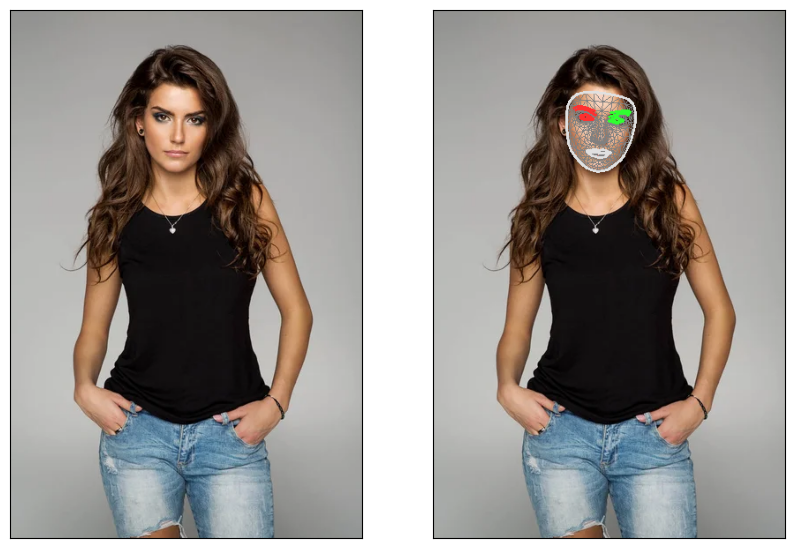

In [13]:
# Inicializando MediaPipe
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Define o caminho da imagem a ser processada
img_path = '/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/modelo.jpg'

# Lê a imagem do arquivo
image = cv2.imread(img_path)

# Especifica os parâmetros para desenhar os landmarks
drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

# Inicializa o modelo FaceMesh
with mp_face_mesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=True,
        min_detection_confidence=0.2) as face_mesh:

    # Converte a imagem de BGR para RGB
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Processa a imagem e detecta landmarks
    results = face_mesh.process(rgb_image)

    # Cria uma cópia da imagem para anotação
    annotated_image = image.copy()

    # Itera sobre os landmarks detectados e desenha na imagem anotada
    for face_landmarks in results.multi_face_landmarks:
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
        )
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
        )
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_iris_connections_style()
        )

# Exibe a imagem anotada
plot_images_grid([image, annotated_image], (1,2))

### 4.3.3 - Detecção de Landmarks em vídeos


A detecção de *landmarks* faciais é uma etapa crucial em diversas metodologias e algoritmos de análise facial em visão computacional. Aplicações como reconhecimento de expressão facial, estimativa de pose da cabeça e sistemas de detecção de sonolência dependem significativamente das informações de forma facial fornecidas pela detecção desses pontos chave.

O principal objetivo de um algoritmo de detecção de *landmarks* faciais é identificar automaticamente as localizações desses pontos chave em imagens ou vídeos, permitindo uma análise mais aprofundada das características faciais. Os pontos chave, ou *landmarks*, podem ser descritos como pontos dominantes que representam a localização única de um componente facial, como os cantos da boca ou dos olhos. Alternativamente, podem ser pontos interpolados que conectam esses pontos dominantes ao redor dos componentes faciais e do contorno facial, proporcionando uma representação mais completa da face.

<br>
<center><img src="https://developers.google.com/static/mediapipe/images/solutions/examples/face_landmark.png" width=500></center>
<br>

Formalmente, dado um retrato facial denotado como I, um algoritmo de detecção identifica a localização de D *landmarks* representados por suas coordenadas na imagem, $x = {x1, y1, x2, y2, ..., xD, yD}$, onde $x$ e $y$ indicam as coordenadas de imagem dos *landmarks* faciais. Utilizando o *MediaPipe*, podemos realizar a detecção de maneira eficiente e integrada ao processo de análise de pose corporal. A ferramenta oferece um framework robusto para essa tarefa, permitindo não só identificar, mas também acompanhar os *landmarks* faciais em tempo real, proporcionando assim uma solução abrangente para a análise de movimentos e expressões humanas.

Agora vamos usar `import mediapipe as mp` para importar a biblioteca e detectar os pontos de interesse na prática.


In [14]:
# Inicializando MediaPipe
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

# Substitua 'path/to/your/video.mp4' pelo caminho do seu vídeo original
file_name = '/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/video2.mp4'
video_cap = cv2.VideoCapture(file_name)

clip = VideoFileClip('/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/video2.mp4')
clip.ipython_display(width=500)

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


#### Propriedades do Vídeo e Configuração de Saída

Nesta etapa, são extraídas informações referentes às propriedades do vídeo de entrada, incluindo a taxa de quadros por segundo (fps) e as dimensões espaciais dos quadros, representadas por sua largura e altura. O objetivo é assegurar que o arquivo de saída, destinado a armazenar os frames processados com a identificação dos landmarks faciais, mantenha as mesmas características do vídeo original.

In [ ]:
# Pegando propriedades do vídeo original
fps = int(video_cap.get(cv2.CAP_PROP_FPS))
frame_w = int(video_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_h = int(video_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame_size = (frame_w, frame_h)

# Configurando o vídeo de saída
video_out_file = file_name[:-4] + '_out_landmarks.mp4'
video_output = cv2.VideoWriter(video_out_file, cv2.VideoWriter_fourcc(*'mp4v'), fps, frame_size)

#### Detecção e Anotação de Landmarks Faciais

Nesta seção, procede-se com a execução das etapas de detecção e anotação de landmarks faciais nos quadros do vídeo de entrada. Para tal, é instanciado o modelo FaceMesh da biblioteca MediaPipe, configurado para detectar até um rosto por quadro, refinar os landmarks, e operar com um grau de confiança mínimo de 0.5 tanto para detecção quanto para rastreamento.

Inicialmente, cada quadro é lido sequencialmente. O modelo FaceMesh é aplicado sobre a versão RGB do quadro, e os landmarks faciais identificados são sobrepostos à imagem original. Os quadros processados, contendo os landmarks desenhados, são então gravados sequencialmente no arquivo de vídeo de saída.

A seguir, será executada a detecção dos landmarks faciais, a anotação gráfica destes sobre os quadros correspondentes e a gravação destes quadros no arquivo de saída.

In [ ]:
# Configurando o Face Mesh
with mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as face_mesh:

  while video_cap.isOpened():
    success, image = video_cap.read()

    if not success:
      print("Finalizando por ter chegado ao final do vídeo.")
      break

    # Processando o frame
    image.flags.writeable = False
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    image.flags.writeable = True

    if results.multi_face_landmarks:
      for face_landmarks in results.multi_face_landmarks:
        # Desenhando landmarks no frame
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
        )
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_CONTOURS,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_contours_style())
        mp_drawing.draw_landmarks(
            image=image,
            landmark_list=face_landmarks,
            connections=mp_face_mesh.FACEMESH_IRISES,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_iris_connections_style())

    # Salvando o frame processado no vídeo de saída
    video_output.write(image)

# Liberando os recursos
video_cap.release()
video_output.release()

print("Vídeo processado e salvo com sucesso:", video_out_file)

#### Visualização do Resultado

Finalmente, exibimos o vídeo processado, que agora inclui a sobreposição dos landmarks faciais detectados em cada face presente nos frames.

In [ ]:
clip = VideoFileClip('/content/drive/MyDrive/Second_Brain/0.2_Areas/0.2_Desenvolvimento_Profissional/visao-computacional-main/visao-computacional-main/data/video2_out_landmarks.mp4')
clip.ipython_display(width=500)